# Finetuning VGG16 on Full Segmented Image Data

**This notebook runs on Kaggle**

Fine-tuning pretrained VGG16 model using complete data set and extracting image feature vectors.

This notebook requires:
* Pre-processed CSV file using [data_exploration_and_cleaning.ipynb](data_exploration_and_cleaning.ipynb)
* Segmented images (two segmentation rounds)

In [3]:
# models
import tensorflow as tf
print('TF Version:', tf.__version__)
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# for everything else
import os
import pandas as pd

# for helper modules
import sys
sys.path.append('/kaggle/input/helper-cnn') # change if run locally
import helper_cnn as hp
sys.path.append('/kaggle/input/image_feature_extraction') # change to '../../src/' if run locally
from image_feature_extraction import dump_to_pickle_file, load_from_pickle_file, map_parts_to_features

2024-02-21 10:47:44.341100: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-21 10:47:44.341231: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-21 10:47:44.501947: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TF Version: 2.15.0


In [4]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Feb 21 10:47:57 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Paths and filenames - change depending on your setup & preferences

In [5]:
input_directory = '../input/syrus-image-segmented'
processed_data_csv_file = 'SyrusMasterDataAnonymisedProc.csv'
output_directory = '../working/'
input_images_directory = f'{input_directory}/SyrusImageSegmented/SyrusImageSegmented'
model_pickle_file = 'vgg16_finetuned_segmented_final_full_data.pkl'
feature_map_pickle_file = f'features_{model_pickle_file}'

### Constants

In [6]:
IMG_DIMS = (353, 500) # mode image dimensions
BATCH_SIZE = 32
IMG_SHAPE = IMG_DIMS + (3,)

### Helper functions

In [9]:
# Data generator for training VGG16 model
def get_generator(df, x_col, y_col, input_images_directory, class_labels_col='target'):
    '''
    Creates a data generator for training with the given DataFrame.

    Parameters:
    - df (pd.DataFrame): DataFrame containing image file paths and corresponding labels.
    - x_col (str): Column name representing the image file paths.
    - y_col (str): Column name representing the labels.
    - input_images_directory (str): Directory where the input images are located.
    - class_labels_col (str): Column name representing the class labels, default: 'target'.

    Returns:
    - tf.keras.preprocessing.image.DataFrameIterator: Data generator for training.
    '''
    train_classes = df[class_labels_col].unique().tolist()
    print('Train classes:', train_classes)
    
    datagen_train = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=preprocess_input # make sure to import the VGG16 function!
    )

    train_generator = datagen_train.flow_from_dataframe(
        dataframe=df,
        directory=input_images_directory,
        shuffle=True, # whether to shuffle the data (default)
        x_col=x_col,
        y_col=y_col,
        classes=train_classes,
        class_mode='sparse',
        target_size=IMG_DIMS,
        batch_size=BATCH_SIZE
    )
    
    # Get the class numbers for all the images in the training set:
    cls_train = train_generator.classes
    print(f"number of elements in train_generator: {len(cls_train)}")
    
    return(train_generator)

# Build the Model using VGG16
def get_model(num_classes):
    '''
    Builds a VGG16-based model for image classification.

    Parameters:
    - num_classes (int): Number of classes for classification.

    Returns:
    - tf.keras.models.Sequential: Compiled model for image classification.
    - list: List of metrics used for evaluation.
    '''
    model = VGG16(weights="imagenet", include_top=False, input_shape=IMG_SHAPE)
    
    # points to last layer to ignore the top layer if the object instance include_top was set to True
    last_conv_layer = model.get_layer('block5_conv3')

    conv_model = Model(inputs=model.input,
                       outputs=last_conv_layer.output)

    # Start a new Keras Sequential model.
    new_model = Sequential()

    # Add the convolutional part of the model from above.
    new_model.add(conv_model)

    # The VGG model uses a global average pooling layer before the final dense layer
    # other models may just flatten the final convolutional layer or
    # use other pooling layers so make sure to check the original model architecture.
    new_model.add(tf.keras.layers.GlobalAveragePooling2D())

    # One could experiment with adding other layers like a dropout-layer which may prevent overfitting.
    new_model.add(tf.keras.layers.Dropout(0.2))

    # Add Dense Layer with ReLU Activation: Introduces non-linearity to the network, allowing it to learn complex patterns.
    # ReLU (Rectified Linear Unit) is preferred for its computational efficiency and effectiveness in training
    # deep neural networks by solving the vanishing gradient problem to some extent.
    new_model.add(tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.01)))

    new_model.add(tf.keras.layers.Dropout(0.2))

    # Add a final dense (aka. fully-connected) layer.
    # This is for combining features recognized in the image and calculating predictions
    # note that the number of nodes is the sameas the number of classes.
    new_model.add(tf.keras.layers.Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.01)))
    
    LEARNING_RATE = 1e-5
    optimizer = Adam(learning_rate=LEARNING_RATE)
    print(optimizer.lr.numpy())
    loss = 'sparse_categorical_crossentropy'
    lst_metrics = ['sparse_categorical_accuracy']
    new_model.compile(optimizer=optimizer, loss=loss, metrics=lst_metrics)

    # To fine tune the model, unfreeze the conv_model first:
    conv_model.trainable = True
    # and then freeze the layers you don't want to fine tune
    # Else it keeps running in inference mode, and won't fine tune
    # even if the layers are later set to trainable
    
    # Unlock last two block of convolutional layers (VGG16 does not have BN layers):
    for layer in conv_model.layers:
      if layer.name[:6] != "block5" and layer.name[:6] != "block4":
        layer.trainable = False
    
    return(new_model, lst_metrics)

# Feature extraction
def extract_image_features(model, path_to_images, dump_path):
    '''
    Extracts image features from the GlobalAveragePooling2D layer using a given model.

    Parameters:
    - model (tf.keras.Model): Pre-trained model for feature extraction.
    - path_to_images (str): Path to the directory containing images.
    - dump_path (str): Path to save the extracted features.

    Returns:
    - dict: Dictionary mapping image filenames to their extracted features.
    '''
    feature_extractor = keras.Model(inputs=model.inputs, outputs=model.layers[-5].output)
    image_features = map_parts_to_features(path_to_images, feature_extractor, dump_path, target_size=IMG_DIMS)    
    return image_features

### Data loading and preparation

In [11]:
df= pd.read_csv(os.path.join(input_directory, processed_data_csv_file), index_col=0)
df = df[df['hasImage']==1]
df['FileName'] = df['ItemNumber'].apply(lambda x: x+".jpeg")
df.head()

,ItemNumber,EnglishItemName,GermanItemName,EnglishItemNameClean,GermanItemNameClean,Weight_kg,Entity,CurrentFamily,CurrentSyntegonSubFamily,PVFamily,PVSubFamily,target,hasImage,FileName
0,A3,BAR GRIP,BAR GRIP,Bar grip,Bar grip,NaN,104.0,BAR PARTS,BAR,AXLE & SHAFT PARTS,AXLE,AXLE & SHAFT PARTS_AXLE,1,A3.jpeg
9,A12,BAR SPACING,ABSTANDSTRANGE,Bar spacing,Abstandstrange,NaN,101.0,BAR PARTS,BAR,BAR PARTS,BARS,BAR PARTS_BARS,1,A12.jpeg
10,A13,BAR,Leiste,Bar,Leiste,NaN,110.0,BAR PARTS,BAR,BAR PARTS,BARS,BAR PARTS_BARS,1,A13.jpeg
21,A24,BAR-FEEDER DECK MTG,BAR-FEEDER DECK MTG,Bar feeder deck mtg,Bar feeder deck mtg,NaN,104.0,BAR PARTS,BAR,BAR PARTS,BARS,BAR PARTS_BARS,1,A24.jpeg
22,A25,BAR,Leiste,Bar,Leiste,NaN,110.0,BAR PARTS,BAR,BAR PARTS,BARS,BAR PARTS_BARS,1,A25.jpeg


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7578 entries, 0 to 13449
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ItemNumber                7578 non-null   object 
 1   EnglishItemName           7509 non-null   object 
 2   GermanItemName            7509 non-null   object 
 3   EnglishItemNameClean      7509 non-null   object 
 4   GermanItemNameClean       7509 non-null   object 
 5   Weight_kg                 6446 non-null   float64
 6   Entity                    7509 non-null   float64
 7   CurrentFamily             7578 non-null   object 
 8   CurrentSyntegonSubFamily  7578 non-null   object 
 9   PVFamily                  7578 non-null   object 
 10  PVSubFamily               7578 non-null   object 
 11  target                    7578 non-null   object 
 12  hasImage                  7578 non-null   int64  
 13  FileName                  7578 non-null   object 
dtypes: float64(2

In [13]:
# Check the number of unique classes for the image dataset
num_classes = df['target'].nunique()
num_classes

95

In [14]:
new_order = ['ItemNumber',  'FileName', 'hasImage', 'EnglishItemName', 'GermanItemName', 'EnglishItemNameClean', 'GermanItemNameClean', 'Weight_kg', 'Entity', 'CurrentFamily', 'CurrentSyntegonSubFamily', 'PVFamily', 'PVSubFamily', 'target']
df = df[new_order]
print(df.shape)
df.head()

(7578, 14)


,ItemNumber,FileName,hasImage,EnglishItemName,GermanItemName,EnglishItemNameClean,GermanItemNameClean,Weight_kg,Entity,CurrentFamily,CurrentSyntegonSubFamily,PVFamily,PVSubFamily,target
0,A3,A3.jpeg,1,BAR GRIP,BAR GRIP,Bar grip,Bar grip,NaN,104.0,BAR PARTS,BAR,AXLE & SHAFT PARTS,AXLE,AXLE & SHAFT PARTS_AXLE
9,A12,A12.jpeg,1,BAR SPACING,ABSTANDSTRANGE,Bar spacing,Abstandstrange,NaN,101.0,BAR PARTS,BAR,BAR PARTS,BARS,BAR PARTS_BARS
10,A13,A13.jpeg,1,BAR,Leiste,Bar,Leiste,NaN,110.0,BAR PARTS,BAR,BAR PARTS,BARS,BAR PARTS_BARS
21,A24,A24.jpeg,1,BAR-FEEDER DECK MTG,BAR-FEEDER DECK MTG,Bar feeder deck mtg,Bar feeder deck mtg,NaN,104.0,BAR PARTS,BAR,BAR PARTS,BARS,BAR PARTS_BARS
22,A25,A25.jpeg,1,BAR,Leiste,Bar,Leiste,NaN,110.0,BAR PARTS,BAR,BAR PARTS,BARS,BAR PARTS_BARS


In [15]:
# limiting the model to only train on images and predict 'target' of parts

x_col = 'FileName' # column in the df with local paths to images
y_col = "target" # column in the df with the names of the classes

print("'{}' column contains {} unique classes".format(y_col, df[y_col].nunique()))

'target' column contains 95 unique classes


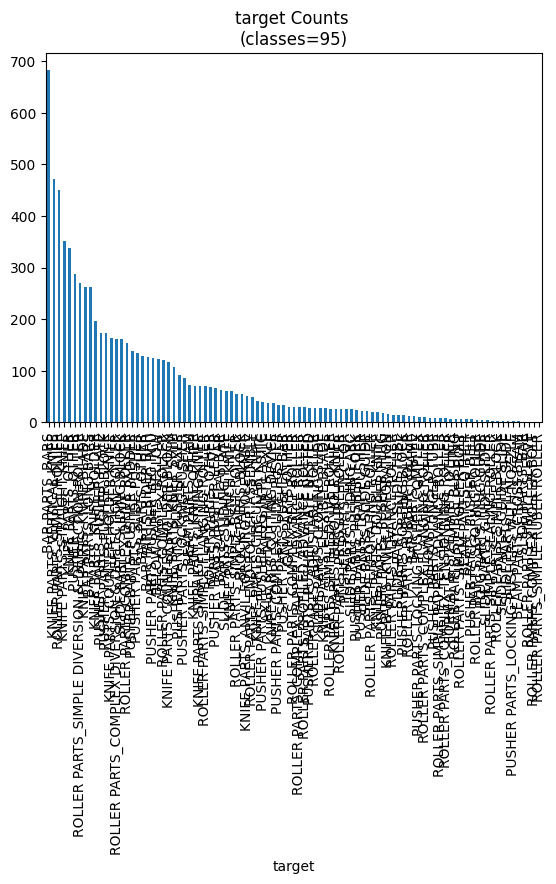

In [16]:
hp.plot_class_balances(df, y_col)

### Model training on all data and feature extraction

In [18]:
model_pickle_path = os.path.join(output_directory, model_pickle_file)
feature_map_pickle_path = os.path.join(output_directory, feature_map_pickle_file)
train_generator = get_generator(df, x_col, y_col, input_images_directory)

# Defining steps size
# Since the step_size can not be in decimal places, it has been rounded
steps_train = round(train_generator.n / BATCH_SIZE)
print(f'step size for training: {steps_train}')

num_classes = df[y_col].nunique()

if not os.path.exists(model_pickle_path):
    # Initialize the model
    new_model, lst_metrics = get_model(num_classes)

    # EarlyStopping callback
    early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, monitor="val_loss", restore_best_weights=True)

    # Start finetuning
    total_epochs = 10
    history1 = new_model.fit(train_generator,
                            epochs=total_epochs,
                            steps_per_epoch=steps_train,
                            initial_epoch=0,
                            callbacks = [early_stopping_cb]
                            )

    # Save the model
    dump_to_pickle_file(new_model, model_pickle_path)

Train classes: ['AXLE & SHAFT PARTS_AXLE', 'BAR PARTS_BARS', 'BLOCK PARTS_BLOCK', 'BAR PARTS_FLAT BAR', 'BAR PARTS_LONG BARS', 'BAR PARTS_OTHER', 'BAR PARTS_RIDER BAR', 'BAR PARTS_FRAME', 'PLUG PARTS_PLUG GUIDE', 'SLIDE PARTS_BAR', 'SLIDE PARTS_CLOSING SLIDE', 'SLIDE PARTS_FLAT SLIDE', 'SLIDE PARTS_GUIDE SLIDE', 'SLIDE PARTS_GUIDE SLIDER', 'SLIDE PARTS_SLIDE GUIDE', 'SLIDE PARTS_SLIDE TUBE', 'SLIDE PARTS_SLIDING ARC', 'SLIDE PARTS_SLIDING BLOCK', 'SLIDE PARTS_SLIDING PLATE', 'BELOW PARTS_BELLOW', 'BELOW PARTS_OTHER', 'BEAM PARTS_BEAM', 'BEAM PARTS_CROSS BEAM', 'BEAM PARTS_OTHER', 'ROLLER PARTS_ADJUSTABLE ROLLER', 'ROLLER PARTS_SIMPLE DIVERSION & DEFLECTION ROLLER', 'ROLLER PARTS_COMPLEX DIVERSION & DEFLECTION ROLLER', 'ROLLER PARTS_COMPLEX DRIVE ROLLER', 'ROLLER PARTS_SIMPLE DRIVE ROLLER', 'ROLLER PARTS_COMPLEX FLANGING ROLLER', 'ROLLER PARTS_OTHER', 'ROLLER PARTS_SIMPLE ROLLER', 'ROLLER PARTS_COMPLEX ROLLER', 'ROLLER PARTS_RUBBER ROLLER', 'ROLLER PARTS_SIMPLE BELT ROLLER', 'ROLLER PAR

In [19]:
if os.path.exists(model_pickle_path):
    new_model = load_from_pickle_file(model_pickle_path)
    print("Loaded model successfully from pickle file")
    # Show test accuracy on all data
    result = new_model.evaluate(train_generator, steps=steps_train)
    print("Classification accuracy of all data: {0:.2%}".format(result[1]))

    if not os.path.exists(feature_map_pickle_path):
        # Extract features
        print("Feature Extraction")
        extract_image_features(new_model, input_images_directory, feature_map_pickle_path)

Loaded model successfully from pickle file
237/237 [==============================] - 165s 583ms/step - loss: 4.7060 - sparse_categorical_accuracy: 0.8310
Classification accuracy of all data: 83.10%
Feature Extraction


Extracting Features:   0%|          | 0/7578 [00:00<?, ?it/s]